In [129]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer

In [130]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

In [131]:
'''Se descargan los corpus necesarios para hacer el procesamiento de lenguaje natural'''
nltk.download('wordnet')  
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/daniel.chancir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/daniel.chancir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/daniel.chancir/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [132]:
df_raw = pd.read_csv('./IMDB Dataset.csv')
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [133]:
'''Por facilidad, se va a utilizar 1 para reseñas positivas y cero para negativas'''
df_raw['sentiment'].replace(['positive', 'negative'], [1, 0], inplace = True)
df_raw.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [134]:
'''Se procede a revisar si hay valores duplicados'''
duplicates = df_raw[df_raw.duplicated()]
print(f'Número de registros duplicados: {len(duplicates)}')

Número de registros duplicados: 418


In [135]:
'''Se verifica que no hayan valores nulos'''
df_raw.isnull().sum()

review       0
sentiment    0
dtype: int64

In [136]:
df_raw.drop_duplicates(inplace=True)
if df_raw.duplicated().sum()==0:   
    print('Se han removido los duplicados')
else:
    print('Todavía hay duplicados')

Se han removido los duplicados


<Axes: xlabel='sentiment', ylabel='count'>

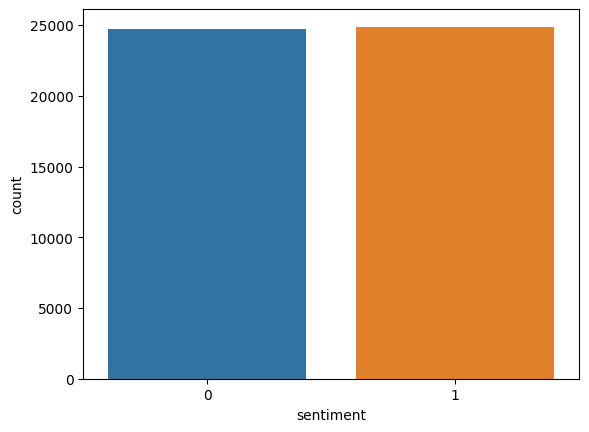

In [137]:
sns.countplot(x=df_raw['sentiment']) 

In [138]:
#LIMPIEZA LAS DE RESEÑAS
stopword_list=nltk.corpus.stopwords.words('english')
stop=set(stopwords.words('english'))

def strip_html(text):
    '''Remueve etiquetas HTML'''
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    '''Remueve corchetes'''
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

def remove_Emails(text):
    pattern=r'\S+@\S+'
    text=re.sub(pattern,'',text)
    return text

def remove_URLS(text):
    '''Remueve etiquetas asociadas a URLs'''
    pattern=r'http\S+'
    text=re.sub(pattern,'',text)
    return text

def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

def remove_numbers(text):
    pattern = r'\d+'
    text = re.sub(pattern, '', text)
    return text

def lowercase_text(text):
    return text.lower()

df_raw['review']=df_raw['review'].apply(denoise_text)
df_raw['review']=df_raw['review'].apply(remove_URLS)
df_raw['review']=df_raw['review'].apply(remove_Emails)
df_raw['review']=df_raw['review'].apply(remove_special_characters)
df_raw['review']=df_raw['review'].apply(remove_numbers)
df_raw['review']=df_raw['review'].apply(lowercase_text)

/var/folders/x8/21809vns62d21gjxm06y07080000gp/T/ipykernel_16455/206476736.py:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/daniel.chancir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


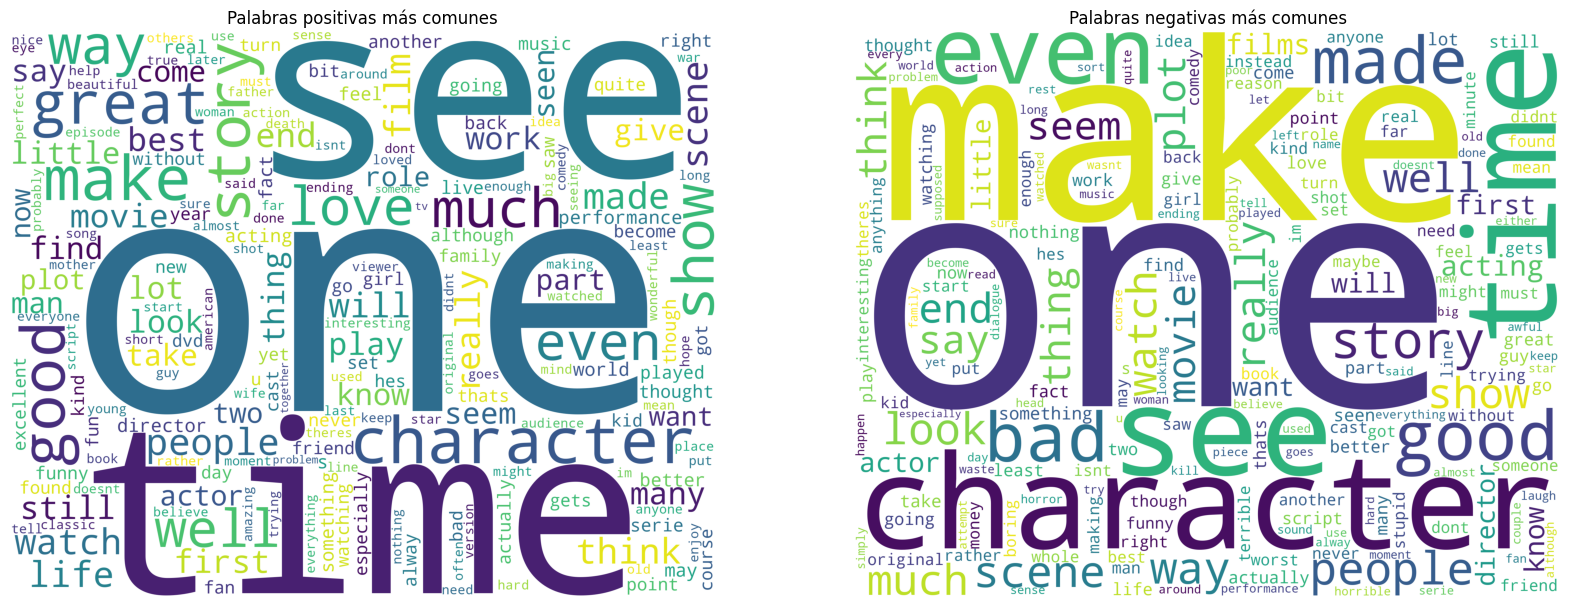

In [139]:
positivedata = df_raw[df_raw['sentiment'] == 1]
positivedata = positivedata['review']
negdata = df_raw[df_raw['sentiment']== 0]
negdata = negdata['review']
nltk.download('stopwords')

def wordcloud_draw(data, color, s):
    '''Se va a crear una nube de palabras para verificar las palabras más comunes en los dos tipos de reseñas'''
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split() if(word!='movie' and word!='film')])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color=color,width=2500,height=2000).generate(cleaned_word)
    plt.imshow(wordcloud)
    plt.title(s)
    plt.axis('off')

plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
wordcloud_draw(positivedata,'white','Palabras positivas más comunes')

plt.subplot(1,2,2)
wordcloud_draw(negdata, 'white','Palabras negativas más comunes')
plt.show()

In [140]:
def get_wordnet_pos(tag):
    """
    Mapeo del etiquetado gramatical para el proceso de lematización
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

In [141]:
def preprocess_review(review):
    """
    Preprocesa las reseñas unsando la técnica de lematización
    """
    lemmatizer = WordNetLemmatizer()
    # Tokeniza las reseñas en palabras
    words = nltk.word_tokenize(review)
    
    # Etiqueta las palabras en su categoría gramatical
    tagged_words = nltk.pos_tag(words)
    
    # Lematiza las palabras usando las etiquetas gramaticales
    lemmatized_words = []
    for word, tag in tagged_words:
        pos = get_wordnet_pos(tag)
        lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_words.append(lemmatized_word)
    
    # Devuelve las palabras en un solo texto
    preprocessed_review = ' '.join(lemmatized_words)
    
    return preprocessed_review

In [142]:
print ('Antes de Lematización.. \n',df_raw['review'][2])
df_raw['review']=df_raw['review'].apply(preprocess_review)
print ('Después de Lematización .. \n',df_raw['review'][2])

Antes de Lematización.. 
 i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air conditioned theater and watching a lighthearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread suspected serial killer while some may be disappointed when they realize this is not match point  risk addiction i thought it was proof that woody allen is still fully in control of the style many of us have grown to lovethis was the most id laughed at one of woodys comedies in years dare i say a decade while ive never been impressed with scarlet johanson in this she managed to tone down her sexy image and jumped right into a average but spirited young womanthis may not be the crown jewel of his career but it was wittier than devil wears prada and more interesting than superman a great comedy to go see with friends
Después de Lematización .. 
 i think this be a wonderful way to spend time on a too hot summer weeke

In [143]:
tokenizer=ToktokTokenizer()

def remove_stopwords(text, is_lower_case=True):
    '''Se remueven palabras comunes (articulos, preposiciones, pronombres) que no aporten mucha información al texto'''
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [144]:
print ('Antes de remover stopwords.. \n',df_raw['review'][2])
df_raw['review']=df_raw['review'].apply(remove_stopwords)


Antes de remover stopwords.. 
 i think this be a wonderful way to spend time on a too hot summer weekend sit in the air condition theater and watch a lighthearted comedy the plot be simplistic but the dialogue be witty and the character be likable even the well bread suspect serial killer while some may be disappoint when they realize this be not match point risk addiction i think it be proof that woody allen be still fully in control of the style many of u have grow to lovethis be the most id laugh at one of woodys comedy in year dare i say a decade while ive never be impress with scarlet johanson in this she manage to tone down her sexy image and jump right into a average but spirited young womanthis may not be the crown jewel of his career but it be witty than devil wear prada and more interesting than superman a great comedy to go see with friend
Después de remover stopwords .. 
 think wonderful way spend time hot summer weekend sit air condition theater watch lighthearted comedy p

In [147]:
print ('Después de remover stopwords .. \n',df_raw['review'][2])

Después de remover stopwords .. 
 think wonderful way spend time hot summer weekend sit air condition theater watch lighthearted comedy plot simplistic dialogue witty character likable even well bread suspect serial killer may disappoint realize match point risk addiction think proof woody allen still fully control style many u grow lovethis id laugh one woodys comedy year dare say decade ive never impress scarlet johanson manage tone sexy image jump right average spirited young womanthis may crown jewel career witty devil wear prada interesting superman great comedy go see friend


In [145]:
df_raw.to_csv('IMDB_reviews_cleaned.csv', index = False)